In [13]:
# Import the f distribution from scipy.stats
from scipy.stats import f, t
import numpy as np
from scipy.optimize import newton, minimize, fmin_tnc
class LinearModel():
    """The Linear Model Class is the parent class to all linear models."""
    
    def __init__(self, add_intercept=True):
        """
        Initializes the class with a boolean indicating whether or not the
        class needs to add a column of 1s to all feature matrices to fit an
        intercept and an empty beta_hat vector that will hold the regression
        model's coefficients.
        
        Parameters
        ----------
        add_intercept : bool, optional
            Tells the class if it needs to add a column of 1s in the first
            column of any data set passed to it, for fitting or prediction. If
            the user does not want to include an intercept in the model, or 
            has already included a column of 1s in the data set for the 
            intercept, this should be set to False. The default is True.

        Returns
        -------
        None.

        """
        self.add_intercept = add_intercept
        self.beta_hat = None
        return
    
    def fit():
        """This method will be overwritten by each of its child classes 
        because the method of fitting the linear model will vary from
        algorithm to algorithm.
        """
        pass
    
    def _predict(self, X):
        """This method predicts the response values of the input array, X, in 
        the scale the model is estimated in; e.g. a logistic model will return
        predictions in log-odds. The columns of X must match the number of 
        columns on the array on which the model was fit. The ordering must be
        identical as well for the predictions to mean anything.

        Parameters
        ----------
        X : numpy ndarray
            A n x m matrix, where the n rows represent observations and the m
            columns represent features of the observations.

        Returns
        -------
        numpy ndarray
            Returns a numpy ndarray with n elements that are the predicted 
            values of the response for each observation in X.

        """
        
        X_copy = self._add_intercept(X)
        
        # Return the predictions.
        return np.matmul(X_copy, self.beta_hat)
    
    def _add_intercept(self, X):
        # If this object needs to add an intercept to new data, add one.
        if self.add_intercept == True:
            # Create an array of 1s equal in length to the observations in X.
            intercept_column = np.repeat(1, repeats=X.shape[0])
            # Insert it at the 0-th column index.
            X_copy = np.insert(X, 0, intercept_column, axis=1)
        # Otherwise, just copy X.
        else:
            X_copy = X
        
        return X_copy
    
class LogisticRegression(LinearModel):
    def __init__(self, add_intercept=True):
        super().__init__()
        return
    
    def _sigmoid(self, beta, X):

        # Calculate the numerator of the inverse logit transformation.
        numerator = 1
        # Calculate the denominator of the inverse logit transformation.
        denominator = 1 + np.exp(-np.dot(X, beta))
        
        return numerator/denominator

    def _log_likelihood(self, beta, X, y):
    
        p_hat = self._sigmoid(beta, X)
    
        # Calculate the log-likelihood of beta given the data.
        log_likelihood = np.sum(y*np.log(p_hat)
                                + (1-y)*(1-np.log(p_hat)))
        
        return log_likelihood
        
    def _neg_log_likelihood(self, beta, X, y):
        return -self._log_likelihood(beta, X, y)

    def _gradient(self, beta, X, y):
        p_hat = self._sigmoid(beta, X)
        return np.dot(X.T, (p_hat-y))
    
    def fit(self, X, y, method="BFGS", max_iter=5000):
        
        assert ((method == "Newton-CG") 
                | (method == "BFGS")), "Valid methods are 'Newton-CG' and 'BFGS'"
        assert ((type(max_iter) == int)
                & (max_iter > 0)), "max_iter must be a postive integer"
        
        # Add an intercept if desired.
        X = self._add_intercept(X)
        
        # Initialize a beta vector at 0.
        beta_start = np.repeat(0, X.shape[1])
        
        # Perform the optimization.
        opt_object = minimize(self._neg_log_likelihood,
                               beta_start,
                               args=(X,y),
                               jac=self._gradient,
                               method=method, 
                               options = {"maxiter": max_iter})
        print(opt_object["message"])
        
        # Set the beta_hat with the optimal result.
        self.beta_hat = opt_object["x"]
        
        return
    
    def predict_probabilities(self, X):
        """
        This method returns predictions of belonging to class 1 in 
        probabilities because the predict method will give predictions in 
        log-odds.

        Parameters
        ----------
        X : numpy array
            A 2-D matrix where rows represent observations and columns 
            represent variables.

        Returns
        -------
        predicted_probabilities : numpy array
            A 1-D array of the predicted probabilites of belonging to class 1.

        """
        
        # Add an intercept if desired.
        X = self._add_intercept(X)
        
        # Calculate the probability of each new observation belonging to 
        # class 1.
        predicted_probabilities = self._sigmoid(self.beta_hat, X)
            
        return predicted_probabilities
    
    def predict_classes(self, X, boundary=0.5):
        """
        This method predicts the class of new observations based on a decision 
        boundary for probability. If predicted probability >= boundary, it is
        predicted to belong to class 1.

        Parameters
        ----------
        X : numpy array
            A 2-D matrix where rows represent observations and columns 
            represent variables.
        boundary : float, optional
            A float on the closed interval between 0 and 1 and is the minimum
            predicted probability to classify a new observation of belonging 
            to class 1. The default is 0.5.

        Returns
        -------
        predicted_classes : numpy array
            The predicted class.

        """
        # Add an intercept if desired.
        X = self._add_intercept(X)
        # Predict the probabilities of belonging to class 1.
        predicted_probabilities = self.predict_probabilities(X)
        # Set predictions to 1 or 0 based on the decision boundary.
        predicted_classes = np.where(predicted_probabilities >= boundary, 1, 0)
        
        return predicted_classes



Desired error not necessarily achieved due to precision loss.
[ 1.57611946 -0.75633672 -0.66826826 -1.52988827]


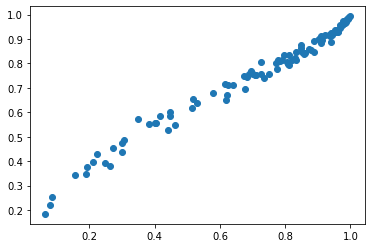

In [15]:
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
np.random.seed(1)

cols = 4
n = 100

beta = np.random.normal(scale=1, size=cols)
x = np.random.normal(size=(n, cols-1))

X = np.insert(x, 0, np.repeat(1, n), axis=1)

log_odds = np.matmul(X, beta) + np.random.normal(scale=0.1, size=n)
probs = 1/(1+np.exp(-log_odds))

my_bernoulli = bernoulli(p=probs)
y = my_bernoulli.rvs()

my_logistic = LogisticRegression()

my_logistic.fit(x, y, method="BFGS")
print(my_logistic.beta_hat)
plt.scatter(my_logistic.predict_probabilities(x), probs)

In [120]:
def _add_intercept(X, add_intercept=True):
        # If this object needs to add an intercept to new data, add one.
        if add_intercept == True:
            # Create an array of 1s equal in length to the observations in X.
            intercept_column = np.repeat(1, repeats=X.shape[0])
            # Insert it at the 0-th column index.
            X_copy = np.insert(X, 0, intercept_column, axis=1)
        # Otherwise, just copy X.
        else:
            X_copy = X
        
        return X_copy

def _sigmoid(beta, X):

        # Calculate the numerator of the inverse logit transformation.
        numerator = 1
        # Calculate the denominator of the inverse logit transformation.
        denominator = 1 + np.exp(-np.dot(X, beta))
        
        return numerator/denominator

def _log_likelihood(beta, X, y):
    
    p_hat = _sigmoid(beta, X)
    
    # Calculate the log-likelihood of beta given the data.
    log_likelihood = np.sum(y*np.log(p_hat)
                            + (1-y)*(1-np.log(p_hat)))
        
    return log_likelihood
        
def _neg_log_likelihood(beta, X, y):
    return -_log_likelihood(beta, X, y)

def gradient(beta, X, y):
    p_hat = _sigmoid(beta, X)
    return np.dot(X.T, (p_hat-y))
beta_start = np.random.normal(size=X.shape[1])
beta_start = np.repeat(0, X.shape[1])

#calling minimizer with Powell's or BFGS method
obj = minimize(_neg_log_likelihood,
         beta_start,
         args=(X,y),
         jac=gradient,
         method='BFGS', 
         options = {'maxiter': 5000})
obj

      fun: -40.090401153757796
 hess_inv: array([[ 0.11598357, -0.04453939, -0.03353057, -0.06439292],
       [-0.04453939,  0.09205664,  0.01831651,  0.03339303],
       [-0.03353057,  0.01831651,  0.07828293,  0.03442046],
       [-0.06439292,  0.03339303,  0.03442046,  0.11687452]])
      jac: array([ 2.82284010e-05, -1.22906488e-06,  1.10587645e-04, -6.45095079e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 48
      nit: 13
     njev: 36
   status: 2
  success: False
        x: array([ 1.57611946, -0.75633672, -0.66826826, -1.52988827])

In [98]:
import statsmodels.api as sm

# building the model and fitting the data
log_reg = sm.Logit(y, X).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.422031
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            3
Date:                Wed, 14 Apr 2021   Pseudo R-squ.:                  0.2991
Time:                        22:06:27   Log-Likelihood:                -42.203
converged:                       True   LL-Null:                       -60.215
Covariance Type:            nonrobust   LLR p-value:                 7.401e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5761      0.348      4.523      0.000       0.893       2.259
x1            -0.7563      0.